In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import Imputer

raw_data_dir = "data_raw"

gc.enable()

def aggregate_and_rename_columns(df, agg_func_list, groupby_col):
    df_agg = df.groupby(groupby_col).agg(agg_func_list)
    df_agg.columns = ["_".join(x) for x in df_agg.columns.ravel()]
    return df_agg

agg_func_list = ['mean', 'max', 'min', 'sum']
#agg_func_list = ['mean']


## Preprocessing

### bureau_balance.csv

In [2]:
print('Read bureau_balance.csv')
buro_bal = pd.read_csv(os.path.join(raw_data_dir, 'bureau_balance.csv'))
print('Buro bal shape : ', buro_bal.shape)

print('transform to dummies')
buro_bal = pd.concat([buro_bal, pd.get_dummies(buro_bal.STATUS, prefix='buro_bal_status')], axis=1).drop('STATUS', axis=1)

print('Counting buros')
buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])

agg_buro_bal = aggregate_and_rename_columns(buro_bal, agg_func_list, 'SK_ID_BUREAU')
agg_buro_bal.columns = ['agg_buro_' + f_ for f_ in agg_buro_bal.columns]

del buro_bal
gc.collect()

Read bureau_balance.csv
Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros


91

### bureau.csv

In [3]:
print('Read bureau.csv')
buro = pd.read_csv(os.path.join(raw_data_dir, 'bureau.csv'))
print('Bureau shape : ', buro.shape)

print('Go to dummies')
buro_credit_active_dum = pd.get_dummies(buro.CREDIT_ACTIVE, prefix='ca_')
buro_credit_currency_dum = pd.get_dummies(buro.CREDIT_CURRENCY, prefix='cu_')
buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')
buro_w_dummies = pd.concat([buro, buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum], axis=1)
buro_w_dummies = buro_w_dummies.drop(['CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE'], axis=1)

del buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum
gc.collect()

Read bureau.csv
Bureau shape :  (1716428, 17)
Go to dummies


14

### Merge bureau and bureau_balance

In [4]:
print('Merge with buro agg')
buro_full = buro_w_dummies.merge(right=agg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))

print('Counting buro per SK_ID_CURR')
nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])

print('Aggregating bureau')
agg_buro = aggregate_and_rename_columns(buro_full, agg_func_list, 'SK_ID_CURR')

print('agg_buro shape : ', agg_buro.shape)

del buro, buro_w_dummies
gc.collect()

Merge with buro agg
Counting buro per SK_ID_CURR
Aggregating bureau
agg_buro shape :  (305811, 304)


42

### previous_application.csv

In [5]:
print('Read previous_application.csv')
prev = pd.read_csv(os.path.join(raw_data_dir, 'previous_application.csv'))
print('Prev shape : ', prev.shape)

print('Go to dummies')
prev_cat_features = [f_ for f_ in prev.columns if prev[f_].dtype == 'object']
prev_dum = pd.DataFrame()
for f_ in prev_cat_features:
    prev_dum = pd.concat([prev_dum, pd.get_dummies(prev[f_], prefix=f_).astype(np.uint8)], axis=1)
prev = pd.concat([prev, prev_dum], axis=1)
del prev_dum
gc.collect()

print("Deal with anomalies")
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)

print('Counting number of Prevs')
nb_prev_per_curr = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])

print('Aggregating prev')
agg_prev = aggregate_and_rename_columns(prev, agg_func_list, 'SK_ID_CURR')
print('agg_prev shape : ', agg_prev.shape)

del prev
gc.collect()


Read previous_application.csv
Prev shape :  (1670214, 37)
Go to dummies
Deal with anomalies
Counting number of Prevs
Aggregating prev
agg_prev shape :  (338857, 652)


63

### POS_CASH_balance.csv

In [6]:
print('Reading POS_CASH')
pos = pd.read_csv(os.path.join(raw_data_dir, 'POS_CASH_balance.csv'))
print('pos shape : ', pos.shape)

print('Go to dummies')
pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)

print('Compute nb of prevs per curr')
nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

print('Aggregating pos_cash')
agg_pos = aggregate_and_rename_columns(pos, agg_func_list, 'SK_ID_CURR')

print('agg_pos shape : ', agg_pos.shape)

del pos, nb_prevs
gc.collect()



Reading POS_CASH
pos shape :  (10001358, 8)
Go to dummies
Compute nb of prevs per curr
Aggregating pos_cash
agg_pos shape :  (337252, 60)


91

### credit_card_balance.csv

In [7]:
print('Reading CC balance')
cc_bal = pd.read_csv(os.path.join(raw_data_dir, 'credit_card_balance.csv'))
print('cc_bal shape : ', cc_bal.shape)

print('Go to dummies')
cc_bal = pd.concat([cc_bal, pd.get_dummies(cc_bal['NAME_CONTRACT_STATUS'], prefix='cc_bal_status_')], axis=1)

nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

print('Compute aggregates')
agg_cc_bal = aggregate_and_rename_columns(cc_bal, agg_func_list, 'SK_ID_CURR')

agg_cc_bal.columns = ['cc_bal_' + f_ for f_ in agg_cc_bal.columns]
print('agg_cc_bal shape : ', agg_cc_bal.shape)

del cc_bal, nb_prevs
gc.collect()

Reading CC balance
cc_bal shape :  (3840312, 23)
Go to dummies
Compute aggregates
agg_cc_bal shape :  (103558, 112)


56

### installments_payments.csv

In [8]:
print('Reading Installments')
inst = pd.read_csv(os.path.join(raw_data_dir, 'installments_payments.csv'))
print('inst shape : ', inst.shape)

print('Compute aggregates')
nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
agg_inst = aggregate_and_rename_columns(inst, agg_func_list, 'SK_ID_CURR')
agg_inst.columns = ['inst_' + f_ for f_ in agg_inst.columns]
print('avg_inst shape : ', agg_inst.shape)
                   

Reading Installments
inst shape :  (13605401, 8)
Compute aggregates
avg_inst shape :  (339587, 28)


### application

In [9]:
print('Read application data (train and test)')
data = pd.read_csv(os.path.join(raw_data_dir, 'application_train.csv'))
test = pd.read_csv(os.path.join(raw_data_dir, 'application_test.csv'))
print('Shapes : ', data.shape, test.shape)

y = data['TARGET']
del data['TARGET']

print("Factorize categorical data")
categorical_feats = [f for f in data.columns if data[f].dtype == 'object']
for f_ in categorical_feats:
    data[f_], indexer = pd.factorize(data[f_])
    test[f_] = indexer.get_indexer(test[f_])

print("Add new features")
# Amount loaned relative to salary
data['LOAN_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
test['LOAN_INCOME_RATIO'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test['ANNUITY_INCOME_RATIO'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']

# Number of overall payments (I think!)
data['ANNUITY LENGTH'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
test['ANNUITY LENGTH'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']

# Social features
data['WORKING_LIFE_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['INCOME_PER_FAM'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
data['CHILDREN_RATIO'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']
test['WORKING_LIFE_RATIO'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
test['INCOME_PER_FAM'] = test['AMT_INCOME_TOTAL'] / test['CNT_FAM_MEMBERS']
test['CHILDREN_RATIO'] = test['CNT_CHILDREN'] / test['CNT_FAM_MEMBERS']
    
print('Shapes : ', data.shape, test.shape)


Read application data (train and test)
Shapes :  (307511, 122) (48744, 121)
Factorize categorical data
Add new features
Shapes :  (307511, 127) (48744, 127)


### Merge all data

In [10]:
print('Merge all dataframes.')
data = data.merge(right=agg_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=agg_buro.reset_index(), how='left', on='SK_ID_CURR')
del agg_buro
gc.collect()

data = data.merge(right=agg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=agg_prev.reset_index(), how='left', on='SK_ID_CURR')
del agg_prev
gc.collect()

data = data.merge(right=agg_pos.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=agg_pos.reset_index(), how='left', on='SK_ID_CURR')
del agg_pos
gc.collect()

data = data.merge(right=agg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=agg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
del agg_cc_bal
gc.collect()

data = data.merge(right=agg_inst.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=agg_inst.reset_index(), how='left', on='SK_ID_CURR')
del agg_inst
gc.collect()

print('Shapes : ', data.shape, test.shape)



Merge all dataframes.
Shapes :  (307511, 1283) (48744, 1283)


In [16]:
print("Save test data to csv")
test.to_csv('test.csv')

In [18]:
print("Save train data to csv")
data.to_csv('train.csv')

Save train data to csv


## Train model

LGBM hyperparameters for better accuracy:
- 'num_leaves': 
    - risk of overfitting 
    - hint: < 2 ^ (max depth)
- 'min_data_in_leaf': 
    - hint: hundred or thousands
- 'max_depth': 
    - risk of overfitting
- 'max_bin'
- 'learning_rate':
    - small learning rate with large 'num_iterations'
- 'dart': use of dropout to avoid overfitting ([paper](https://arxiv.org/abs/1505.01866))

If overfitting:
- Use small max_bin
- Use small num_leaves
- Use min_data_in_leaf and min_sum_hessian_in_leaf
- Use bagging by set bagging_fraction and bagging_freq
- Use feature sub-sampling by set feature_fraction
- Use bigger training data
- Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
- Try max_depth to avoid growing deep tree


{
    'n_estimators'=4000,
    'learning_rate'=0.03,
    'num_leaves'=30,
    'colsample_bytree'=.8,
    'subsample'=.9,
    'max_depth'=7,
    'reg_alpha'=.1,
    'reg_lambda'=.1,
    'min_split_gain'=.01,
    'min_child_weight'=2,
    'silent'=-1,
    'verbose'=-1,
    }

lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 30,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'scale_pos_weight': 2,
    'drop_rate': 0.02
}

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.03,
        num_leaves=30,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
    )

    clf = LGBMClassifier( 
        boosting='dart', 
        application='binary',
        learning_rate=0.1,
        min_data_in_leaf=30,
        num_leaves=31,
        max_depth=-1,
        feature_fraction=0.5,
        scale_pos_weight=2,
        drop_rate=0.02
     )



In [28]:
folds = KFold(n_splits=5, shuffle=True, random_state=546789)

preds_data = np.zeros(data.shape[0])
preds_test = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in data.columns if f not in ['SK_ID_CURR']]

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    trn_x, trn_y = data[feats].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = data[feats].iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.01,
        num_leaves=30,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
    )
        
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )
    
    preds_data[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    preds_test += clf.predict_proba(test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, preds_data[val_idx])))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, preds_data)) 
test['TARGET'] = preds_test

test[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index=False)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.747185	valid_1's auc: 0.735848
[200]	training's auc: 0.755718	valid_1's auc: 0.742772
[300]	training's auc: 0.7672	valid_1's auc: 0.751822
[400]	training's auc: 0.780262	valid_1's auc: 0.76228
[500]	training's auc: 0.791502	valid_1's auc: 0.770509
[600]	training's auc: 0.800084	valid_1's auc: 0.776005
[700]	training's auc: 0.806995	valid_1's auc: 0.779579
[800]	training's auc: 0.813144	valid_1's auc: 0.782263
[900]	training's auc: 0.818674	valid_1's auc: 0.784275
[1000]	training's auc: 0.82359	valid_1's auc: 0.785816
[1100]	training's auc: 0.828144	valid_1's auc: 0.787001
[1200]	training's auc: 0.832618	valid_1's auc: 0.78787
[1300]	training's auc: 0.836877	valid_1's auc: 0.788588
[1400]	training's auc: 0.841049	valid_1's auc: 0.789149
[1500]	training's auc: 0.845155	valid_1's auc: 0.789759
[1600]	training's auc: 0.848925	valid_1's auc: 0.790127
[1700]	training's auc: 0.852558	valid_1's auc: 0.790465

Fold  4 AUC : 0.792187
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.745769	valid_1's auc: 0.733089
[200]	training's auc: 0.755415	valid_1's auc: 0.740889
[300]	training's auc: 0.767026	valid_1's auc: 0.749551
[400]	training's auc: 0.780393	valid_1's auc: 0.759277
[500]	training's auc: 0.791805	valid_1's auc: 0.76719
[600]	training's auc: 0.800438	valid_1's auc: 0.771961
[700]	training's auc: 0.807492	valid_1's auc: 0.775403
[800]	training's auc: 0.813837	valid_1's auc: 0.777861
[900]	training's auc: 0.819372	valid_1's auc: 0.779488
[1000]	training's auc: 0.824466	valid_1's auc: 0.780651
[1100]	training's auc: 0.829068	valid_1's auc: 0.78159
[1200]	training's auc: 0.833483	valid_1's auc: 0.782327
[1300]	training's auc: 0.837667	valid_1's auc: 0.782956
[1400]	training's auc: 0.841727	valid_1's auc: 0.783366
[1500]	training's auc: 0.845605	valid_1's auc: 0.783766
[1600]	training's auc: 0.849258	valid_1's auc: 0.78404
[1700]	training's auc: 0.85283

## Result analysis

In [20]:
def display_importances(feature_importance_df):
    # Plot feature importances
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()


def display_roc_curve(y, preds_data, folds_idx):
    plt.figure(figsize=(6,6))
    scores = [] 

    # Plot the roc curve for each fold
    for n_fold, (_, val_idx) in enumerate(folds_idx):  
        fpr, tpr, thresholds = roc_curve(y.iloc[val_idx], preds_data[val_idx])
        score = roc_auc_score(y.iloc[val_idx], preds_data[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold {:d} (AUC = {:.4f})'.format(n_fold + 1, score))
    
    # Plot ROC curves for all labelled data
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y, preds_data)
    score = roc_auc_score(y, preds_data)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = {:.4f} $\pm$ {:.4f})'.format(score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


def display_precision_recall(y, preds_data, folds_idx):
    plt.figure(figsize=(6,6))
    scores = [] 
    # Plot the roc curve for each fold
    for n_fold, (_, val_idx) in enumerate(folds_idx):  
        fpr, tpr, thresholds = roc_curve(y.iloc[val_idx], preds_data[val_idx])
        score = average_precision_score(y.iloc[val_idx], preds_data[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AP fold {:d} (AUC = {:.4f})'.format(n_fold + 1, score))

    # Plot the precision/recall curve 
    precision, recall, thresholds = precision_recall_curve(y, preds_data)
    score = average_precision_score(y, preds_data)
    plt.plot(precision, recall, color='b',
             label='Avg ROC (AUC = {:.4f} $\pm$ {:.4f})'.format(score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('LightGBM Recall / Precision')
    plt.legend(loc="best")
    plt.tight_layout()
    
    plt.savefig('recall_precision_curve.png')

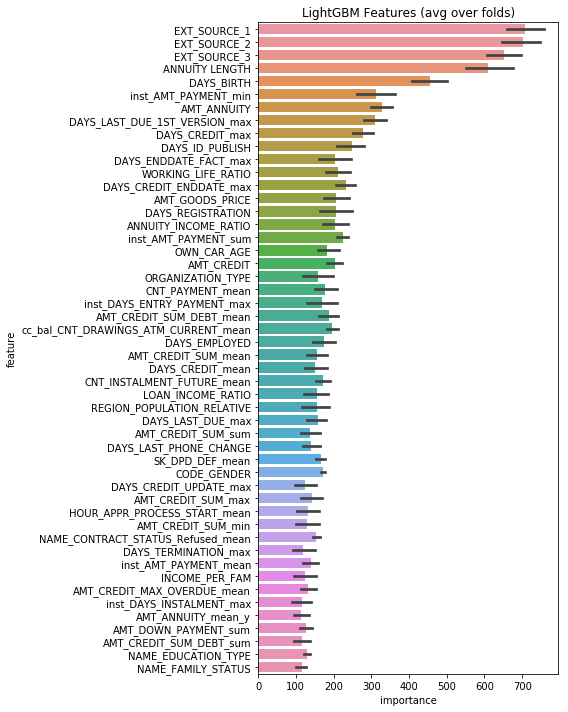

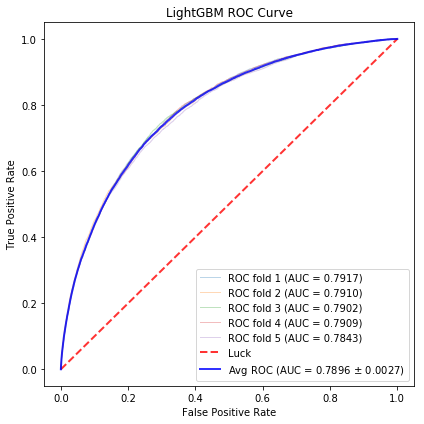

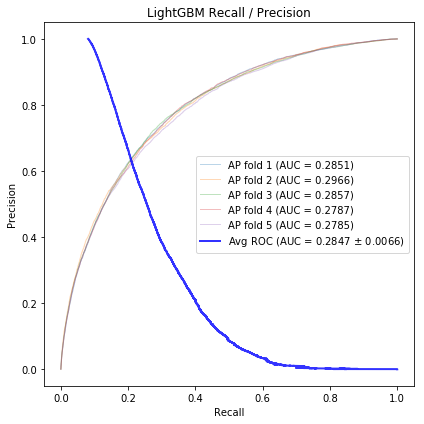

In [21]:
folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(data)]
display_importances(feature_importance_df)
display_roc_curve(y, preds_data, folds_idx)
display_precision_recall(y, preds_data, folds_idx)